In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from scipy.stats import gmean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.colors
import seaborn
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
raw_kin_df = pd.read_excel('../data/01152018rubisco_kinetics.xlsx', index_col=0)
wt_only_df = raw_kin_df[raw_kin_df.mutant == False]

# Some measurements are made at much higher temps and are not comparable.
# TODO: collect pH of measurements so we can restrict to similar range
high_T = wt_only_df.Temp_C > 30
wt_only_df = wt_only_df.loc[np.logical_not(high_T)]

# Filtered DataFrame used for most plots below.
# Only variants with all the data
kin_df = wt_only_df.copy()
has_KMs = np.logical_and(np.isfinite(kin_df.Kc), np.isfinite(kin_df.Ko))
has_kcats = np.logical_and(np.isfinite(kin_df.Vc), np.isfinite(kin_df.Vo))
has_kons = np.logical_and(np.isfinite(kin_df.kon_C), np.isfinite(kin_df.kon_O))
has_all = np.logical_and(np.logical_and(has_KMs, has_kcats), has_kons)
kin_df = kin_df[has_all]

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_df = wt_only_df[wt_only_df.savir]
nonsavir_df = wt_only_df[wt_only_df.savir == False]

# Group by RuBisCO form
grouped_form = wt_only_df.groupby('form_text')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print wt_only_df.shape[0], 'total WT RuBisCOs'
print kin_df.shape[0], 'RuBisCOs with all core kinetic data measured'

158 total WT RuBisCOs
136 RuBisCOs with all core kinetic data measured


In [35]:
def fit_power_law(log_xs, log_ys):
    """Returns exponent, prefactor, r2, p_val, exponent std_err."""
    mask = ~np.isnan(log_xs) & ~np.isnan(log_ys)
    xs_ = log_xs[mask]
    ys_ = log_ys[mask]
    
    mask = np.isfinite(xs_) & np.isfinite(ys_)
    xs_ = xs_[mask]
    ys_ = ys_[mask]
    
    slope, intercept, r_val, p_val, stderr = linregress(xs_, ys_)
    r2 = r_val**2
    
    prefactor = np.exp(intercept)
    exponent = slope
    return exponent, prefactor, r2, p_val, stderr

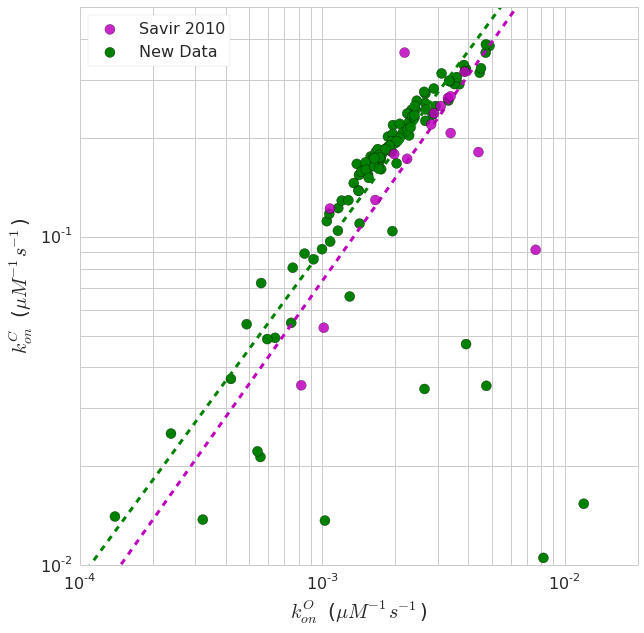

In [46]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

# Regress on savir FI data to get previous fit (not clearly reported). 
savir_FIs = savir_df[savir_df.form_text == 'I']
konOs = np.log(savir_FIs.kon_O)
konCs = np.log(savir_FIs.kon_C)
exp_savir, pre_savir, r2, p_val, stderr = fit_power_law(konOs, konCs)

# Regress against FI data, which is closest to the front. 
all_FIs = wt_only_df[wt_only_df.form_text == 'I']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
exp_allFI, pre_allFI, r2, p_val, stderr = fit_power_law(konOs, konCs)

plt.xscale('log')
plt.yscale('log')

plt.scatter(savir_df.kon_O, savir_df.kon_C, c='m', s=100, alpha=0.85, label='Savir 2010', zorder=10)
plt.scatter(nonsavir_df.kon_O, nonsavir_df.kon_C, c='g', s=100, label='New Data')

xs = np.arange(1e-4, 2e-2, 0.01)
plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='m', lw=3, ls='--')
plt.plot(xs, np.power(xs, exp_allFI)*pre_allFI, c='g', lw=3, ls='--')

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 2e-2)
plt.ylim(1e-2, 0.5)

plt.show()

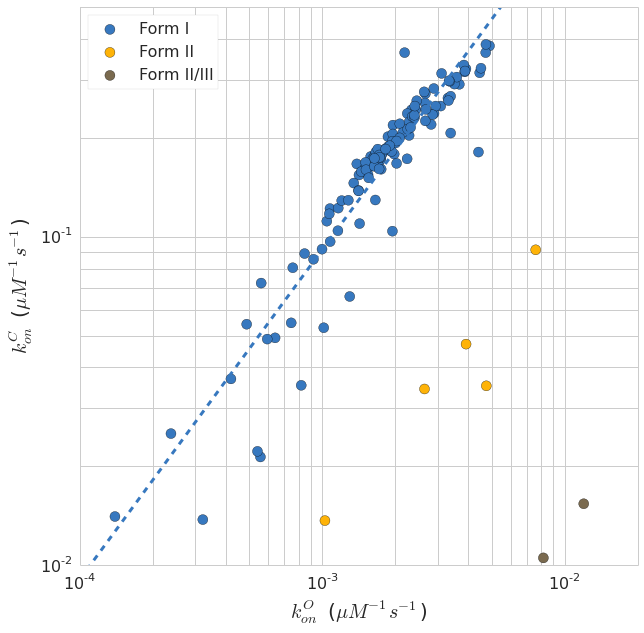

In [47]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

# Regress against FI data, which is closest to the front. 
all_FIs = wt_only_df[wt_only_df.form_text == 'I']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
exp_allFI, pre_allFI, r2, p_val, stderr = fit_power_law(konOs, konCs)

plt.xscale('log')
plt.yscale('log')

for i, (group, gdf) in enumerate(grouped_form):
    if group == 'III':
        continue
    label = 'Form %s' % group
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.kon_O, gdf.kon_C, c=c, s=100, label=label)

plt.plot(xs, np.power(xs, exp_allFI)*pre_allFI, c=named_colors[0], lw=3, ls='--')

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 2e-2)
plt.ylim(1e-2, 0.5)

plt.show()